## imports

In [2]:
# Execute before using this notebook if using google colab
kernel = str(get_ipython())
if 'google.colab' in kernel:    
    !wget https://raw.githubusercontent.com/fredzett/rmqa/master/utils.py -P local_modules -nc 
    !npx degit fredzett/rmqa/data data
    import sys
    sys.path.append('local_modules')

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from patsy import dmatrices
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.model_selection import train_test_split
from scipy.stats import mode

from subprocess import call
from IPython.display import Image

plt.rcParams['font.size'] = 12
plt.rcParams['figure.figsize'] = [9,7]
plt.rcParams['figure.dpi'] = 80
plt.rcParams["axes.spines.right"] = False
plt.rcParams["axes.spines.top"] = False

# Bagging: Decision trees

Let continue with our example from last session. Let's try to build a __decision tree__ with 
- y = car is from USA (origin = 1) or not (origin = 2 or 3) 
- X = horsepower and weight

For this we will 

- create a new y variable called (US) taking value of 1 if car is from USA and 0 if otherwise

In [43]:
df = pd.read_csv("./data/Auto.csv")
df["US"] = np.where(df["origin"]==1,1,0)
y, X = dmatrices("US ~ horsepower + weight -1", df)

Using the above data we can build a decision tree easily using the `sklearn` module

In [44]:
tree_clf = DecisionTreeClassifier(max_depth=3) # change max_depth to make tree smaller or larger
tree_clf.fit(X,y)

DecisionTreeClassifier(max_depth=3)

In [45]:
tree_clf.score(X,y)

0.8035714285714286

In [105]:
y.shape

(392, 1)

The model has an __accuracy score__ of $\approx 0.80$. Note that we could easily improve the score by loosing some the restrictions on building the tree (here: max_depth). However, doing this will lead to significant overfitting. 

Now let's extend this example by building a __bagging classifier__ using $B$ decision trees.

For each $b=1, 2, \ldots, B$  we need to:

- take a bootstrap sample

- train (i.e. fit) a decision tree model to the sampled data

Once we have done this we have $B$ trained decision trees. We can than calculate prediction for each of the $B$ trees and aggregate the prediction to one overall prediction. 

Let's build a bagging function for classification step by step. 

The function should

- take $X$, $y$ and $B$ as input 

- return $B$ fitted models and their scores as output



In [46]:
def bootstrap(X,y):
    n = len(y)
    idx = np.random.choice(range(n), size=n, replace=True)
    return X[idx,:], y[idx]

In [55]:
def bagging(X,y,B):
    
    models = [] # stores the trees
    scores = [] # stores the accuracy scores
    
    for b in range(B):
        
        # Take bootstrap sample
        Xnew, ynew = bootstrap(X,y)
        
        # Build / train a decision tree
        tree = DecisionTreeClassifier()
        tree.fit(Xnew, ynew)
        
        # Store results
        models.append(tree)
        scores.append(tree.score(X, y))
    
    return models, scores

In [62]:
def predict(models, X,y):
    return np.array([m.predict(X) for m in models])

In [80]:
def aggregation(predictions):
    return mode(predictions, axis=0)[0].reshape(-1,1)

In [92]:
models, _ = bagging(X,y,1000)

In [93]:
predictions = predict(models, X,y)
yhat = aggregation(predictions)

In [94]:
df = pd.DataFrame(predictions).T
df["ytrue"] = y
df["yhat"] = yhat

In [208]:
np.random.seed(124)
X = np.random.randn(100000).reshape(1000,100)
y = np.sum([X[:,i]**2 + X[:,i]**3 + np.sin(X[:,i])**5 for i in range(X.shape[1])], axis=0)

In [209]:
from sklearn.ensemble import BaggingClassifier, RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression

In [220]:
m1 = RandomForestRegressor()
m1.fit(X,y)
yhat_rf = m1.predict(X)

In [221]:
m2 = LinearRegression()
m2.fit(X,y)
yhat_lr = m2.predict(X)

In [228]:
m3 = GradientBoostingRegressor(learning_rate=0.2)
m3.fit(X,y)
yhat_gb = m3.predict(X)

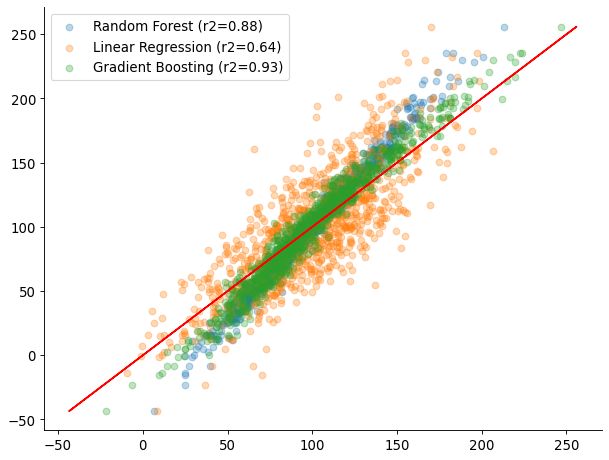

In [229]:
plt.scatter(yhat_rf, y, alpha=0.3, label=f"Random Forest (r2={m1.score(X,y):.2})")
plt.plot(y,y, color="red")
plt.scatter(yhat_lr,y, alpha=0.3, label=f"Linear Regression (r2={m2.score(X,y):.2})");
plt.scatter(yhat_gb,y, alpha=0.3, label=f"Gradient Boosting (r2={m3.score(X,y):.2})");
plt.legend();

In [ ]:
plt.plot